In [19]:
# install requirements
!pip install pretrainedmodels==0.7.4
!pip install segmentation_models_pytorch
!pip install -U git+https://github.com/albu/albumentations

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=9777ab1816fa53d8b732a7e0cdcd41a61f42304b689211515e359c470d690331
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=47acc0e22d991d04344366b854f7f7dcf0d8edde2811265ed8ec5d54e78ae206
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ivr6s0ia
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ivr6s0ia
     |████████████████████████████████| 952kB 4.5MB/s 
  Created wheel for

In [20]:

from google.colab import drive
import os
import random
import shutil
import zipfile
import os
import random
import zipfile
import shutil
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import albumentations as albu
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
from albumentations.pytorch import ToTensor
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
!mkdir /content/dataset/
!mkdir /content/dataset/train
!mkdir /content/dataset/val
!mkdir /content/dataset/test
!mkdir /content/dataset/train/images
!mkdir /content/dataset/val/images
!mkdir /content/dataset/test/images
!mkdir /content/dataset/train/masks
!mkdir /content/dataset/val/masks
!mkdir /content/dataset/test/masks

In [13]:
# Распаковка датасета
with zipfile.ZipFile('/content/drive/My Drive/dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [14]:
# folder list
list_folders = ['insta_100_images_dataset']

# cycle by folders
for folder in list_folders:
  list_images = os.listdir(os.path.join('/content/', folder, 'images'))
  random.shuffle(list_images)
  length = len(list_images)
  train = list_images[:int(0.8 * length)]
  val   = list_images[int(0.8 * length):int(0.9 * length)]
  test  = list_images[int(0.9 * length):]  
  for im in train:
    shutil.copyfile(os.path.join('/content', folder, 'images', im), os.path.join('/content/dataset/train/images', folder+im))
    shutil.copyfile(os.path.join('/content', folder, 'masks', im), os.path.join('/content/dataset/train/masks', folder+im))
  for im in val:
    shutil.copyfile(os.path.join('/content', folder, 'images', im), os.path.join('/content/dataset/val/images', folder+im))
    shutil.copyfile(os.path.join('/content', folder, 'masks', im), os.path.join('/content/dataset/val/masks', folder+im))
  for im in test:
    shutil.copyfile(os.path.join('/content', folder, 'images', im), os.path.join('/content/dataset/test/images', folder+im))
    shutil.copyfile(os.path.join('/content', folder, 'masks', im), os.path.join('/content/dataset/test/masks', folder+im))

In [36]:
def get_training_augmentation():
  train_transform = [
      albu.Resize(256, 256),
      albu.HorizontalFlip(p=0.5),
      albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.03, p=0.5, border_mode=0),
      albu.Normalize(),
  ]
  return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
          albu.Resize(256, 256),
          albu.Normalize()
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [37]:
class Dataset(BaseDataset):
  def __init__(self, images_dir, masks_dir, 
               augmentation=None, preprocessing=None,):
      
    self.names = os.listdir(images_dir)
    self.images_paths =  [os.path.join(images_dir, name) for name in self.names]
    self.masks_paths = [os.path.join(masks_dir, name) for name in self.names]
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    
  def __getitem__(self, i):
      # read data
      image = cv2.imread(self.images_paths[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_paths[i], 0)
      mask = np.clip(mask,0,1)
      mask = np.expand_dims(mask, axis=2)

              
      # apply augmentations
      if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
      
      # apply preprocessing
      if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
          
      return image, mask
      
  def __len__(self):
      return len(self.names)

In [38]:
# Lets look at data we have
x_train_dir = '/content/dataset/train/images'
y_train_dir = '/content/dataset/train/masks'

x_valid_dir = '/content/dataset/val/images'
y_valid_dir = '/content/dataset/val/masks'

x_test_dir = '/content/dataset/test/images'
y_test_dir = '/content/dataset/test/masks'

dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


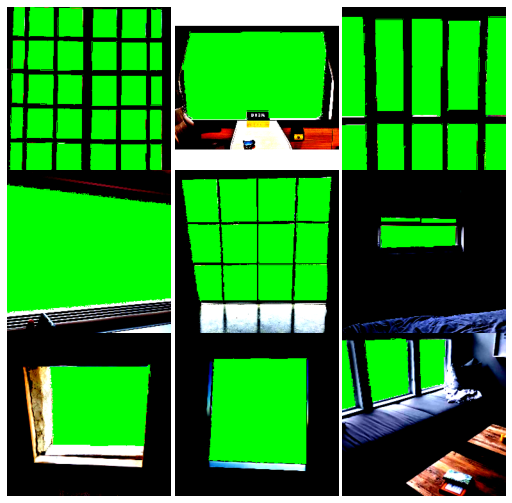

In [39]:
h,w = 3,3

fig,ax = plt.subplots(h,w,figsize=(9,round((9/w)*h)))
for i in range(h*w):
  image, mask = dataset[i]
  ax[(i)%h][i//w].set_xticklabels([])
  ax[(i)%h][i//w].set_yticklabels([])
  ax[(i)%h][i//w].axis('off')
  mask = mask.squeeze()
  image[mask!=0] = (0,255,0)
  ax[(i)%h][i//w].imshow(image)
  
plt.subplots_adjust(wspace=0, hspace=0)
fig.show()

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [48]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    activation='sigmoid'
)
model.to(device)


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [49]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [50]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False)

In [51]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    
    if activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score

class DiceLoss(nn.Module):
  __name__ = 'dice_loss'

  def __init__(self, eps=1e-7, activation='sigmoid'):
      super().__init__()
      self.activation = activation
      self.eps = eps

  def forward(self, y_pr, y_gt):
      return 1 - f_score(y_pr, y_gt, beta=1., eps=self.eps, threshold=None, activation=self.activation)


class BCEDiceLoss(DiceLoss):
  __name__ = 'bce_dice_loss'

  def __init__(self, eps=1e-7, activation='sigmoid'):
      super().__init__(eps, activation)
      self.bce = nn.BCEWithLogitsLoss(reduction='mean')

  def forward(self, y_pr, y_gt):
      dice = super().forward(y_pr, y_gt)
      bce = self.bce(y_pr, y_gt)
      return dice + bce

In [52]:
loss = BCEDiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [53]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [54]:
max_score = 0

for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decrease decoder learning rate to 1e-6!')


Epoch: 0
valid: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, bce_dice_loss - 1.365, iou_score - 0.01851]
Model saved!

Epoch: 1
valid: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, bce_dice_loss - 1.374, iou_score - 0.08201]
Model saved!

Epoch: 2
valid: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s, bce_dice_loss - 1.344, iou_score - 0.0347]

Epoch: 3
valid: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, bce_dice_loss - 1.321, iou_score - 0.04597]

Epoch: 4
valid: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s, bce_dice_loss - 1.313, iou_score - 0.08934]
Model saved!

Epoch: 5
valid: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s, bce_dice_loss - 1.302, iou_score - 0.09157]
Model saved!

Epoch: 6
valid: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s, bce_dice_loss - 1.275, iou_score - 0.2654]
Model saved!

Epoch: 7
valid: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s, bce_dice_loss - 1.219, iou_score - 0.592]
Model saved!

Epoch: 8
valid: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s, bce_dic

In [55]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [56]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=device,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 10/10 [00:00<00:00, 25.14it/s, bce_dice_loss - 1.141, iou_score - 0.7959]


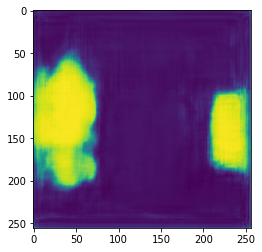

In [60]:
#import torch.nn.functional as F
img, mask = next(iter(test_loader))
img = img.to(device)
output = model(img)

output = output.squeeze()
plt.imshow(output.detach().cpu().numpy())
plt.show()

In [62]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir
)

In [63]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

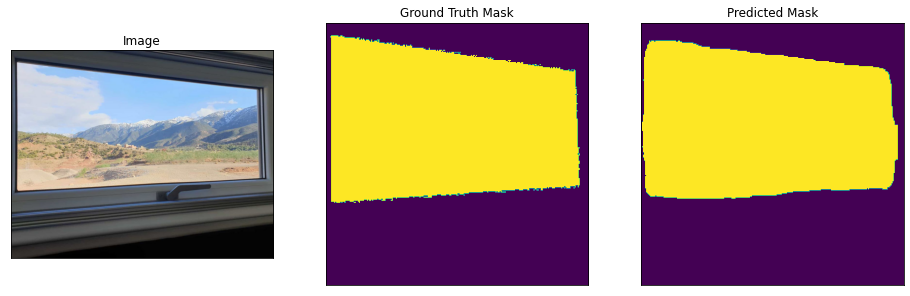

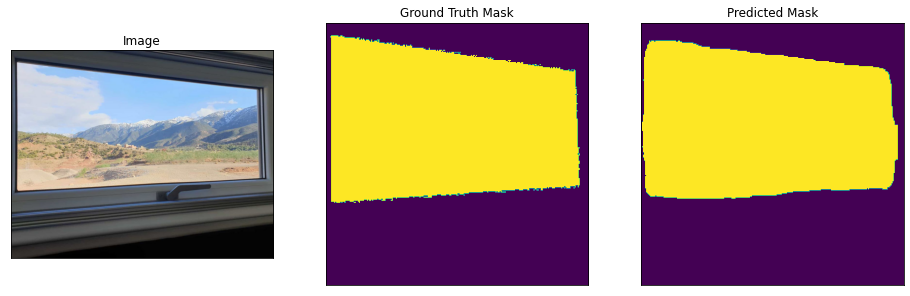

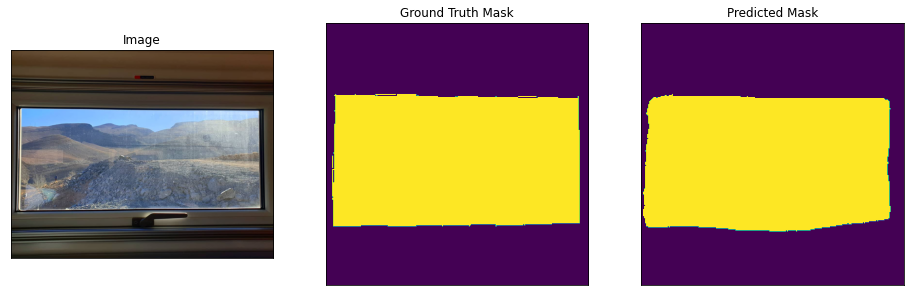

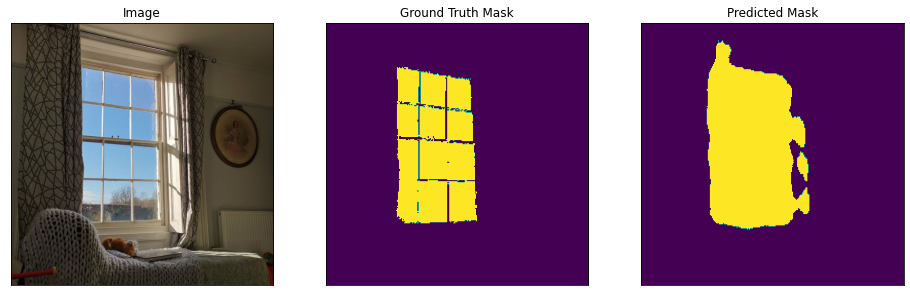

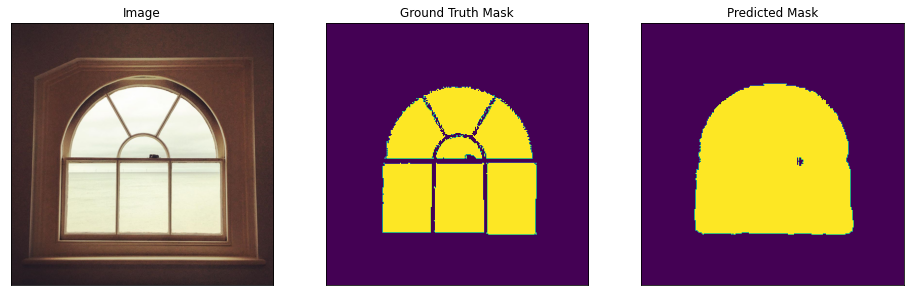

In [64]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )